# Performing differential expression analysis with AlphaQuant and investigating the results

Below some code how to perform differential expression testing with AlphaQuant. This means we do a pairwise comparison of biological conditions and some volcano plot visualizations.

## Specifying input files

In order to run differential analyses you need:
* an input file from a proteomics search engine (e.g. DIA-NN, Spectronaut, AlphaPept etc.), or a pre-formatted file
* a sample mapping file that maps each sample to a condition (e.g.  sample 'brain_replicate_1' is mapped to condition 'brain'). In the GUI, there is some functionality to help create such a file
* (optional) a results directory can be defined on where to save the data
* (optional) a list where we specify, which conditions we compare

AlphaQuant is compatible to the default output tables of most common proteomics search engines. Detailed specifications on which tables you need can be found 
in our  [README](https://github.com/MannLabs/alphaquant/blob/main/README.md#section-title).


In [1]:
INPUT_FILE = "./data/mouse_tissues/mouse_tissues_100prot_200ng.aq_reformat.tsv" 
SAMPLEMAP_FILE = "./data/mouse_tissues/samplemap_200.tsv"
CONDPAIRS_TO_COMPARE = [('spleen', 'testis'), ('lungs', 'brain')]
RESULTS_DIRECTORY = "./data/mouse_tissues/results_pairwise_analysis"

In [2]:
#displaying the samplemap file
import pandas as pd
display(pd.read_csv(SAMPLEMAP_FILE, sep='\t'))


,sample,condition
0,20230926_OA2_CaWe_aQuant_mBrain_200ng_01.raw,brain
1,20230926_OA2_CaWe_aQuant_mBrain_200ng_02.raw,brain
2,20230926_OA2_CaWe_aQuant_mBrain_200ng_03.raw,brain
3,20230926_OA2_CaWe_aQuant_mBrain_200ng_04.raw,brain
4,20230926_OA2_CaWe_aQuant_mBrain_200ng_05.raw,brain
...,...,...
74,20230926_OA2_CaWe_aQuant_mTestis_200ng_06.raw,testis
75,20230926_OA2_CaWe_aQuant_mTestis_200ng_07.raw,testis
76,20230926_OA2_CaWe_aQuant_mTestis_200ng_08.raw,testis
77,20230926_OA2_CaWe_aQuant_mTestis_200ng_09.raw,testis


## Run AlphaQuant in pairwise-comparison mode

Now we can use the 'run_pipeline' command from AlphaQuant. This performs normalization between sample and then differential expression testing. The main output is a table of proteins with fold changes and an fdr value as a result of the differential expression test. Due to AlphaQuant's tree based approach, sensitivity is in general higher as compared to standard approaches like the t-test, i.e. there should be more proteins with significant fdr, especially for lower fold changes.

In [3]:
import alphaquant.run_pipeline as aq_pipeline

aq_pipeline.run_pipeline(input_file=INPUT_FILE, samplemap_file=SAMPLEMAP_FILE, 
                         condpairs_list=CONDPAIRS_TO_COMPARE, results_dir=RESULTS_DIRECTORY, runtime_plots=False)

start processeing condpair ('spleen', 'testis')
normalized within conditions
median -0.8106630368583518, mode -0.8282891052920638
using median for shift
shift comparison by 0.8106630368583518
normalized between conditions
t_ion2nonan_sw 0.005326747894287109
t_intensity_selection 0.14977693557739258
t_ion2nonan_sw 0.005289793014526367
t_intensity_selection 0.14105892181396484
checked 0 of 2783 ions
checked 2000 of 2783 ions
checked 0 of 100 prots

condition pair ('spleen', 'testis') finished!

start processeing condpair ('lungs', 'brain')
normalized within conditions
median -0.2582211316884333, mode -0.0907526108990453
using mode for shift
shift comparison by 0.0907526108990453
normalized between conditions
t_ion2nonan_sw 0.005290985107421875
t_intensity_selection 0.15001392364501953
t_ion2nonan_sw 0.005164146423339844
t_intensity_selection 0.14277315139770508
checked 0 of 2783 ions
checked 2000 of 2783 ions
checked 0 of 100 prots

condition pair ('lungs', 'brain') finished!



## Inspecting output tables

The main output tables for each pairwise comparison are located in the results folder and are named
 * spleen_VS_testis.results.tsv
 * lungs_VS_brain.results.tsv

Let's load one of them:
 
 

In [4]:
import pandas as pd

df_spleen_testis  = pd.read_csv(RESULTS_DIRECTORY + "/spleen_VS_testis.results.tsv", sep='\t')
display(df_spleen_testis)

,condpair,protein,fdr,pval,log2fc,consistency_score,num_ions,pseudoint1,pseudoint2
0,spleen_VS_testis,Q8CI94,3.125000e-16,1.000000e-16,-1.040899,31.666667,60,1.044438e+07,2.163733e+07
1,spleen_VS_testis,D3Z041;P41216,3.125000e-16,1.000000e-16,-4.659861,29.516667,77,5.883125e+06,1.370927e+08
2,spleen_VS_testis,Q99LY9,1.255306e-03,8.661608e-04,-0.588774,11.666667,28,2.727216e+06,4.105937e+06
3,spleen_VS_testis,P59325,4.117360e-11,2.099854e-11,0.632691,13.500000,18,3.276746e+06,2.159240e+06
4,spleen_VS_testis,Q9D0E1;Q9D0E1-2,3.125000e-16,1.000000e-16,1.439193,36.425000,62,3.540029e+07,1.396464e+07
...,...,...,...,...,...,...,...,...,...
95,spleen_VS_testis,D3YZP9,1.985113e-10,1.032259e-10,0.653678,4.500000,6,3.751285e+05,2.207966e+05
96,spleen_VS_testis,E9PZ00;J3QPG5;K3W4L3;Q61207;Q8BFQ1,1.310335e-11,6.420642e-12,0.952685,3.000000,6,1.671290e+07,1.128829e+07
97,spleen_VS_testis,Q8VE47,4.623356e-10,2.542846e-10,0.948651,3.000000,3,4.127215e+05,2.140239e+05
98,spleen_VS_testis,Q8K1R7,7.244205e-13,3.477219e-13,1.907509,2.000000,2,7.996686e+02,2.131536e+02


The fold changes are defined as condition1 - condition2. For example spleen_VS_testis means that a log2fc is calculated by log2(intensity_spleen/intensity_testis)

## Visualizing results - basic plots

### Volcano plot

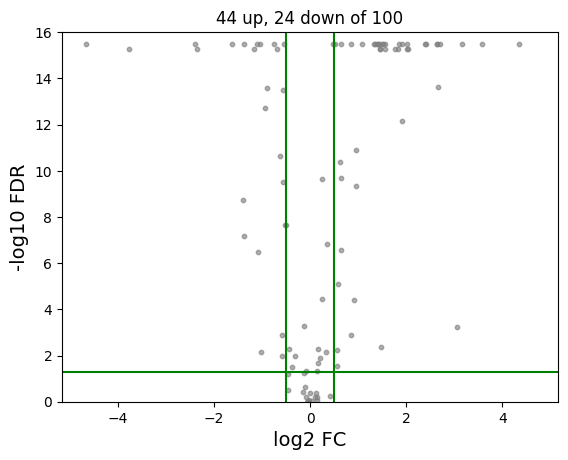

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'44 up, 24 down of 100'}, xlabel='log2 FC', ylabel='-log10 FDR'>)

In [5]:
import alphaquant.plotting.pairwise as aq_plotting_pairwise

aq_plotting_pairwise.volcano_plot(df_spleen_testis)

### Normalization plot

The normalization plot gives all pairs of foldchanges between all samples for the two conditions. The peak of the distributions should be centered around 0. If not, there might be a problem with the normalization.

In [6]:
normalized_df = pd.read_csv(RESULTS_DIRECTORY + "/spleen_VS_testis.normed.tsv", sep='\t')
samplemap_df = pd.read_csv(SAMPLEMAP_FILE, sep='\t')

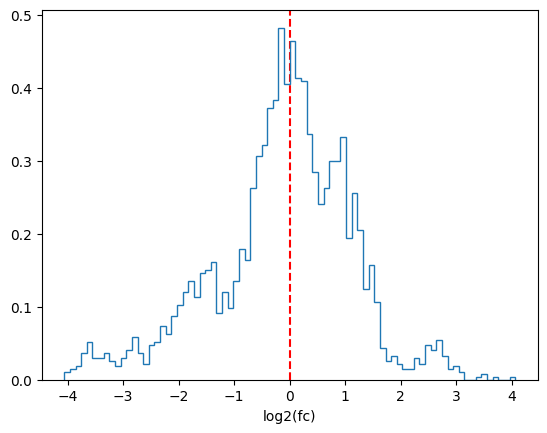

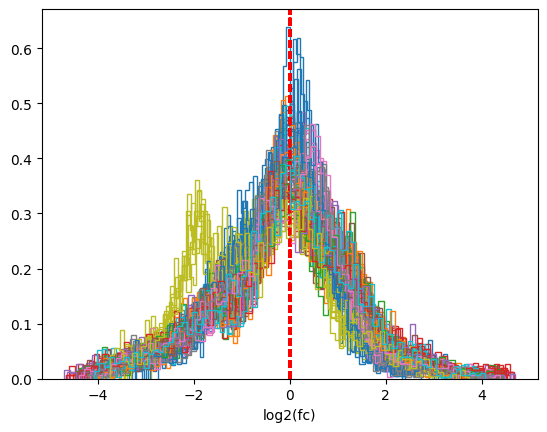

In [7]:
aq_plotting_pairwise.plot_normalization_overview(normalized_df, samplemap_df)

## Inspect and visualize proteoforms

Peptides that show different quantititative behaviour than other peptides can indicate proteoforms. The logic behind this can be elucidated with a simple example. Let's assume we have a protein with 3 peptides in spleen and testis. The protein itself shows no regulation between the two tissues. Therefore, we can expect that neither of the peptides changes between the conditions. The log2 fold changes for all the peptides should be the same. Now, let's assume that one of the peptides is phosphorylated in testis. If fifty percent of the copies of this peptide carry a phosphorylation, then only half as much **non-modified** peptide should be detectable in testis. This means, that in out spleen_vs_testis condition, we expect the unmodified version of the phosphorylated peptide to be up-regulated, while the other peptides have no regulation. The fold changes should differ. With AlphaQuant, we can investigate systematic differences between fold changes and report peptides that behave differently than expected.

We write out a `.proteoforms.tsv` table for each pair of conditions. Let's load the one for spleen and testis:

In [8]:
import pandas as pd
proteoform_df = pd.read_csv(RESULTS_DIRECTORY + "/spleen_VS_testis.proteoforms.tsv", sep='\t')
display(proteoform_df)

,protein,proteoform_id,cluster,is_reference,peptides,num_peptides,quality_score,log2fc,fraction_of_peptides,fcdiff
0,A0A0A0MQM0;P63242,A0A0A0MQM0;P63242_0,0,True,SEQ_VHLVGIDIFTGK_;SEQ_RNDFQLIGIQDGYLSLLQDSGEVR...,3,19.0,-0.167828,1.00,0.000000
1,A0A0R4J1N9;P40630;P40630-2,A0A0R4J1N9;P40630;P40630-2_0,0,True,SEQ_EQLTPSQLMGMEK_;SEQ_QAYIQLAK_;SEQ_SWEEQMAEV...,5,6.0,0.263662,1.00,0.000000
2,A0A0R4J2B2;Q6WVG3,A0A0R4J2B2;Q6WVG3_0,0,True,SEQ_FNFLEQAFDK_;SEQ_YILDYLR_,2,3.0,2.640351,0.67,0.000000
3,A0A0R4J2B2;Q6WVG3,A0A0R4J2B2;Q6WVG3_1,1,False,SEQ_MFTQQQPQELAR_,1,2.0,3.213556,0.33,0.573205
4,A0A1B0GRR3;P62281,A0A1B0GRR3;P62281_0,0,True,SEQ_EAIEGTYIDK_;SEQ_DYLHYIR_,2,7.0,-0.568436,0.67,0.000000
...,...,...,...,...,...,...,...,...,...,...
113,Q9WUM5,Q9WUM5_1,1,False,SEQ_LVGGTTPGK_;SEQ_QGTFHSQQALEYGTK_,2,11.0,-0.233103,0.50,0.787528
114,Q9WVA2,Q9WVA2_0,0,True,SEQ_FIDTSQFILNR_,1,7.0,-0.568245,0.50,0.000000
115,Q9WVA2,Q9WVA2_1,1,False,SEQ_SKPVFSESLSD_,1,5.0,0.053295,0.50,0.621540
116,Q9Z0N1,Q9Z0N1_0,0,True,SEQ_NEVLMVNIGSLSTGGR_;SEQ_VGQEIEVRPGIVSK_;SEQ_...,5,8.0,-0.681451,0.71,0.000000


An important column is termed "fcdiff", which quantifies the fold change difference between peptides and groups of peptides. Let's filter for proteoforms with a log2 fold change difference of at least 0.7, using an AlphaQuant function:

In [9]:
import alphaquant.utils.diffquant_utils as aq_diffquant_utils

proteoform_df_filtered = aq_diffquant_utils.filter_proteoform_df(proteoform_df=proteoform_df, min_num_peptides=1, fcdiff_cutoff=0.5)
display(proteoform_df_filtered)

,protein,proteoform_id,cluster,is_reference,peptides,num_peptides,quality_score,log2fc,fraction_of_peptides,fcdiff
3,A0A0R4J2B2;Q6WVG3,A0A0R4J2B2;Q6WVG3_1,1,False,SEQ_MFTQQQPQELAR_,1,2.000000,3.213556,0.33,0.573205
5,A0A1B0GRR3;P62281,A0A1B0GRR3;P62281_1,1,False,SEQ_VLLGETGK_,1,3.333333,-0.013920,0.33,0.554516
16,D3Z041;P41216,D3Z041;P41216_1,1,False,SEQ_LVDVEEMNYLASK_;SEQ_AILDDLLK_,2,2.000000,-5.429804,0.15,0.805136
23,G3UXZ5;P97371,G3UXZ5;P97371_1,1,False,SEQ_NAYAVLYDIILK_,1,3.000000,0.956535,0.25,0.539073
31,P05064,P05064_1,1,False,SEQ_ALQASALK_;SEQ_FSNEEIAMATVTALR_;SEQ_LQSIGTE...,6,19.000000,0.631593,0.40,0.617565
39,P11499,P11499_2,2,False,SEQ_EDQTEYLEERR_,1,5.000000,0.807947,0.04,0.996075
47,P35235-1,P35235-1_1,1,False,SEQ_SGMVQTEAQYR_,1,3.000000,0.774771,0.20,0.618878
50,P52196,P52196_1,1,False,SEQ_EGHPVTSEPSRPEPAVFK_,1,1.500000,0.849166,0.17,3.102610
70,Q71RI9;Q71RI9-2,Q71RI9;Q71RI9-2_1,1,False,SEQ_AIILNTPHNPLGK_,1,1.333333,-2.208015,0.50,0.824153
91,Q99LC3,Q99LC3_1,1,False,SEQ_LTLPEYLPPHAVIYIDVPVPEVQSR_;SEQ_EIAQQLGMK_,2,6.125000,-0.443827,0.20,0.526612


This leaves only a few proteins of interest. Let's visualize them in order to check them out further. For this we must load a few modules in AlphaQuant:

A0A0R4J2B2;Q6WVG3


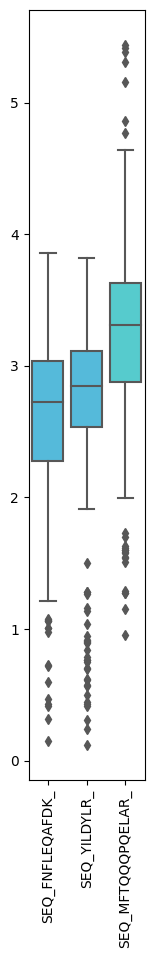

A0A1B0GRR3;P62281


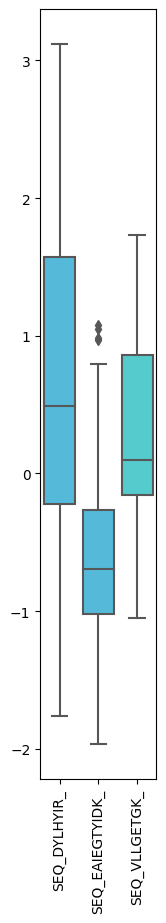

D3Z041;P41216


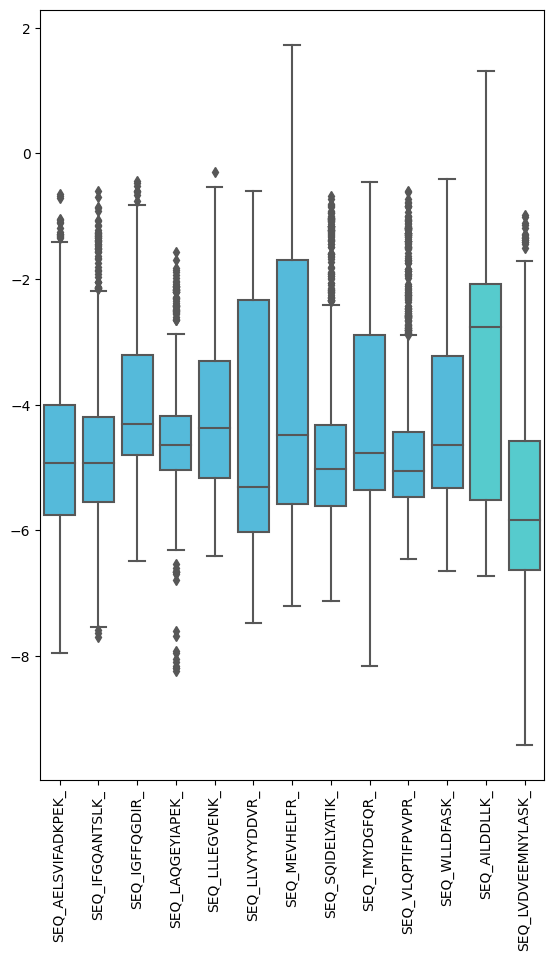

G3UXZ5;P97371


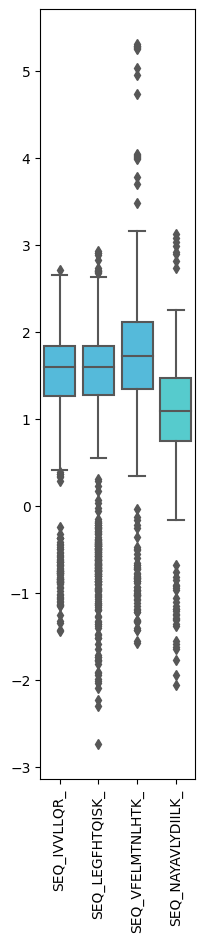

P05064


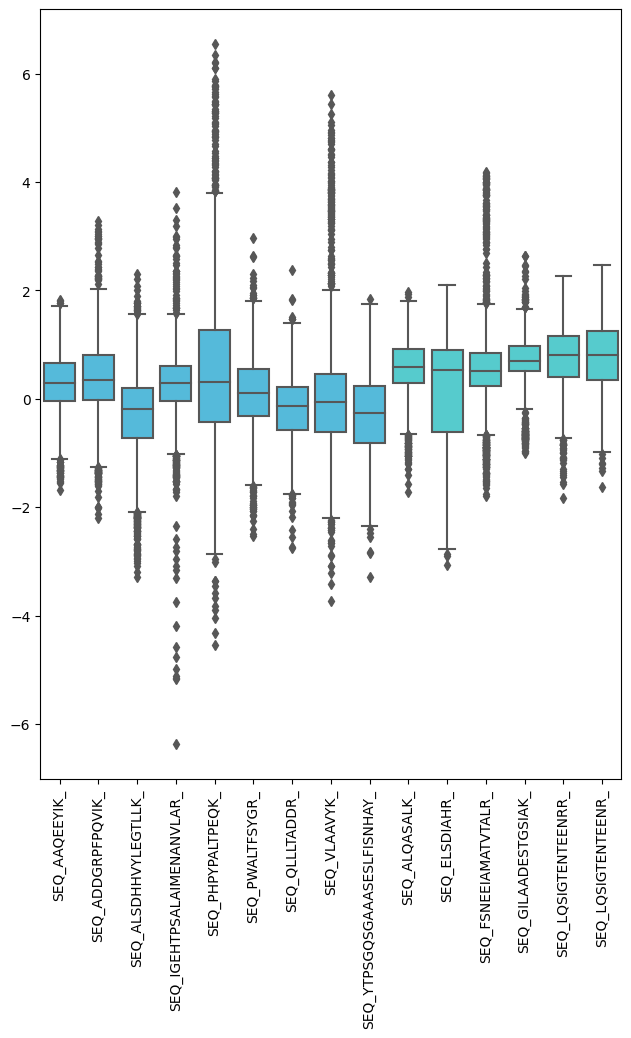

P11499


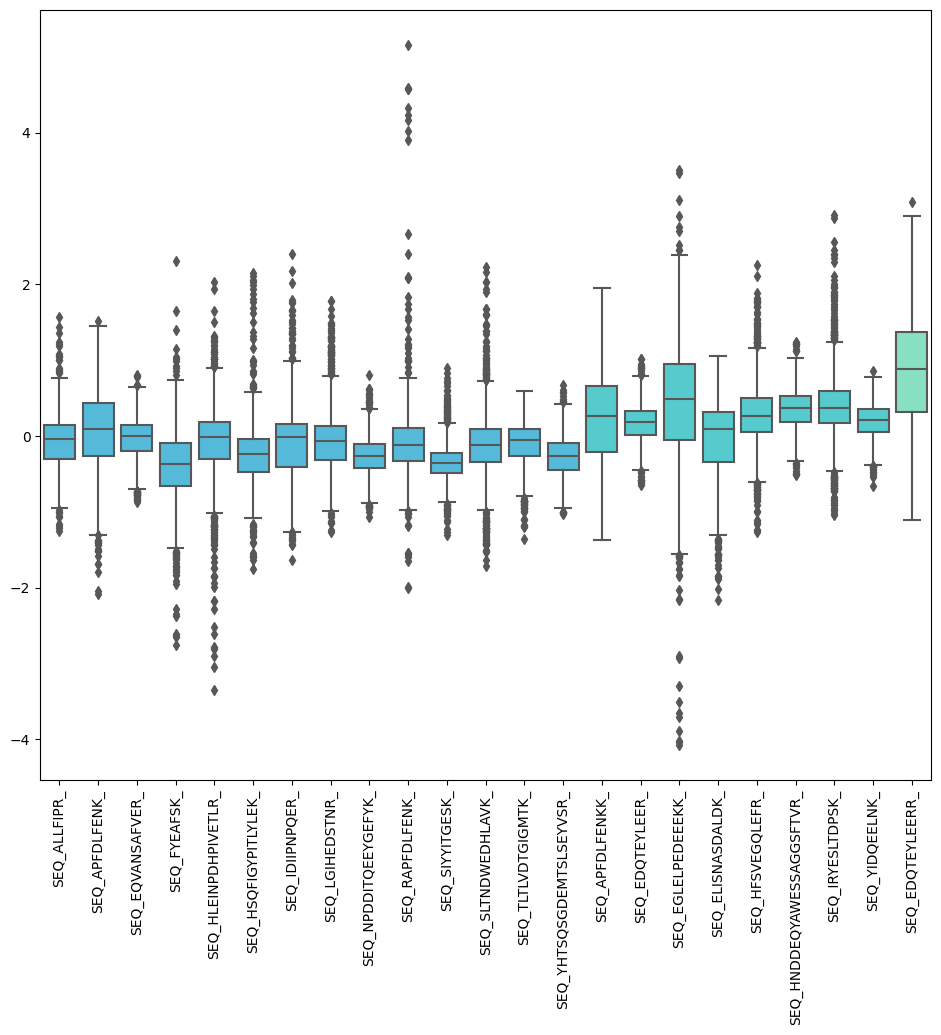

P35235-1


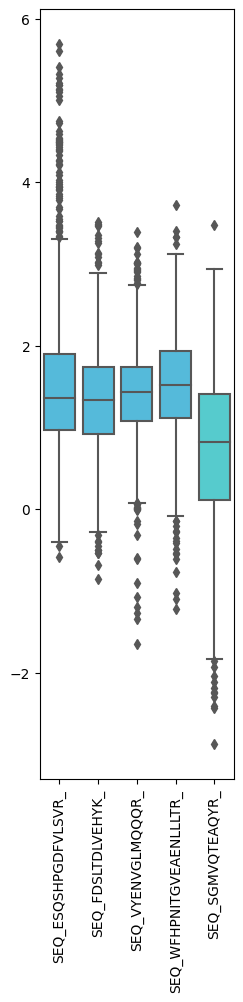

P52196


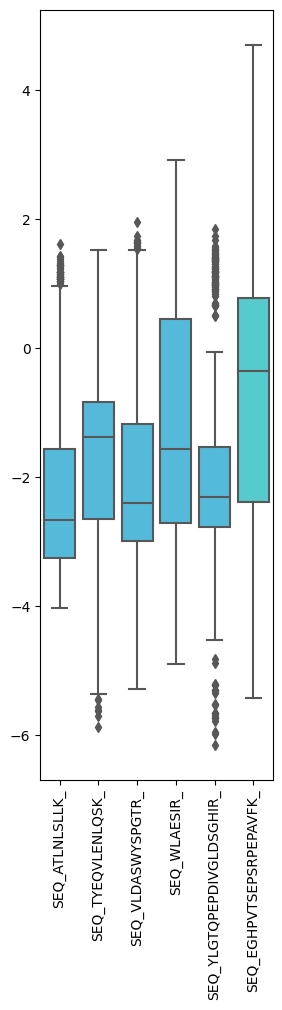

Q71RI9;Q71RI9-2


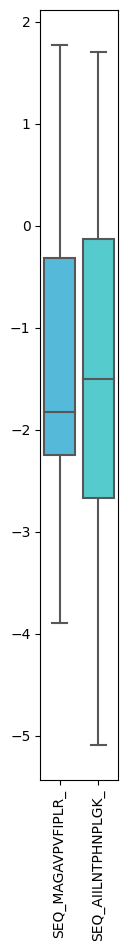

Q99LC3


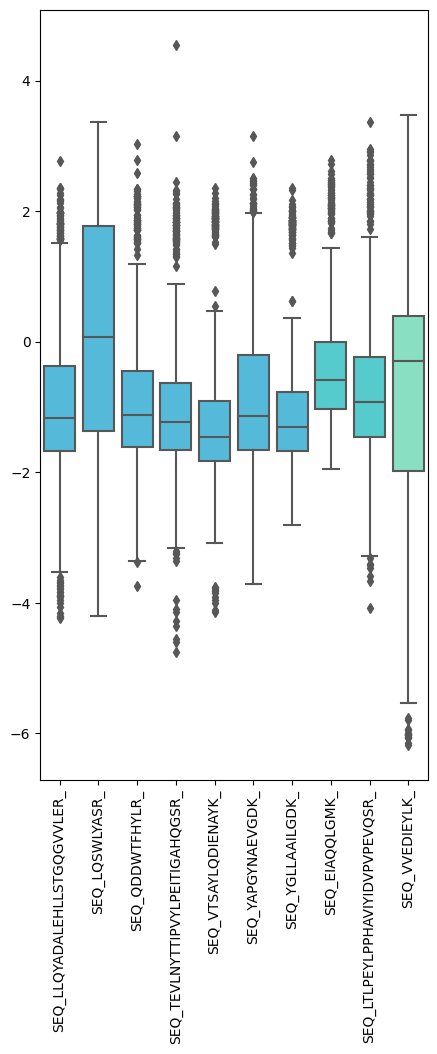

Q9WUM5


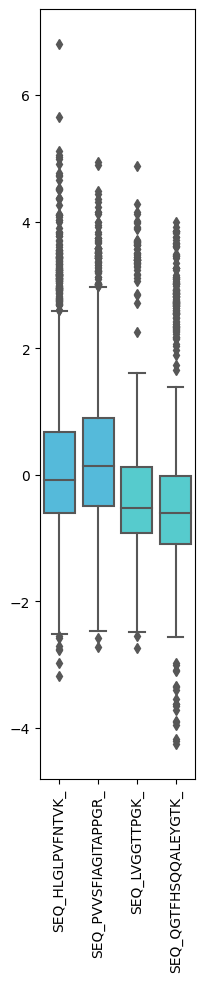

Q9WVA2


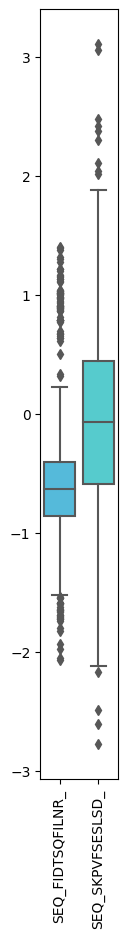

Q9Z0N1


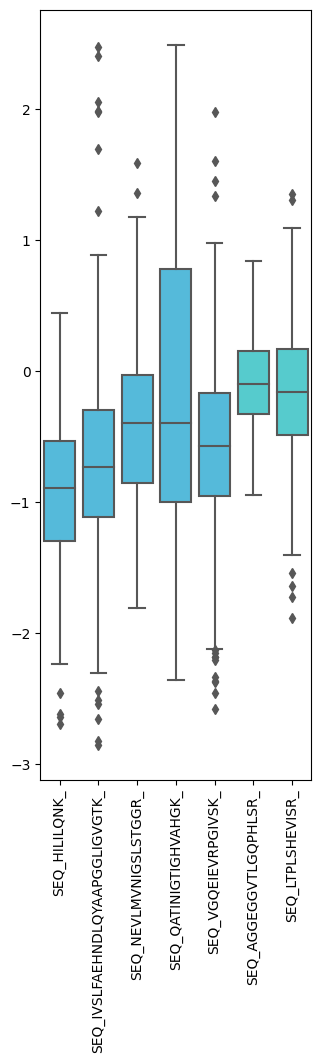

In [10]:
import alphaquant.plotting.fcviz as aq_fcviz
import alphaquant.plotting.base_functions as aq_base_functions
import alphaquant.utils.utils as aq_utils

plotconfig = aq_fcviz.PlotConfig()
plotconfig.colorlist = aq_base_functions.AlphaPeptColorMap().colorlist #change the colorlist to the AlphaPept colorlist, not necessary

quantification_info = aq_fcviz.CondpairQuantificationInfo(("spleen", "testis"), RESULTS_DIRECTORY, SAMPLEMAP_FILE)

#load the trees containing the tree-based quantification info
condpair_tree = aq_utils.read_condpair_tree("spleen", "testis", results_folder=RESULTS_DIRECTORY)

protein2node = {x.name : x for x in condpair_tree.children}
for protein_of_interest in proteoform_df_filtered['protein'].unique():
    print(protein_of_interest)
    protein_node = protein2node[protein_of_interest]
    cluster_plotter = aq_fcviz.FCPlotter(protein_node, quantification_info, plotconfig)
        
    

Of those potential candidates, P11499 looks very consistent, let's investigate it further, using visualizations of the AlphaMap package, for this we first need to install it:

In [11]:
!pip install --no-deps alphamap

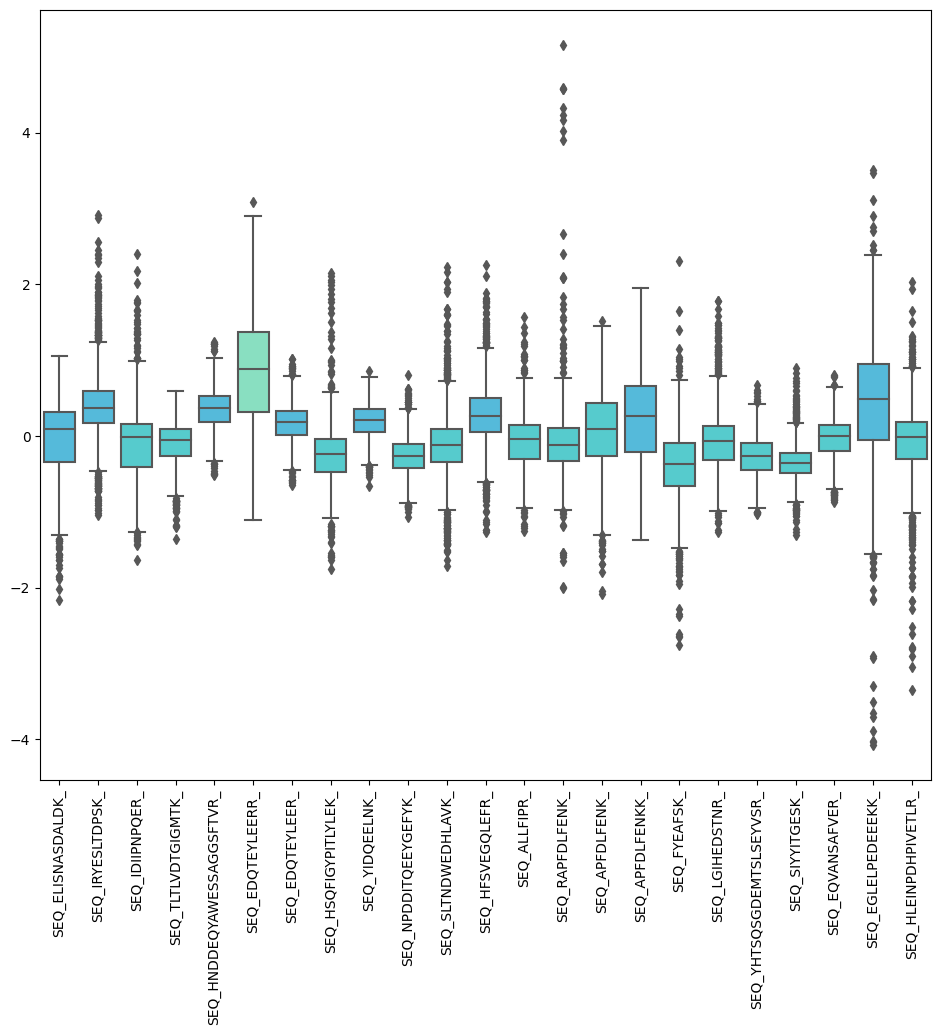

/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/alphamap/organisms_data.py:135: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  uniprot_file = pd.read_csv(os.path.join(DATA_PATH, uniprot_name))


In [12]:
import alphaquant.plotting.fcviz as aq_fcviz
import alphaquant.plotting.base_functions as aq_base_functions
import alphaquant.plotting.alphamapviz as aq_alphamapviz
import copy

plotconfig = aq_fcviz.PlotConfig()
plotconfig.rescale_factor_y = 1
plotconfig.colorlist = aq_base_functions.AlphaPeptColorMap().colorlist #change the colorlist to the AlphaPept colorlist, not necessary
plotconfig.set_config_to_order_along_protein_sequence(organism="Mouse") #now we order the peptides along the protein sequence

quantification_info = aq_fcviz.CondpairQuantificationInfo(("spleen", "testis"), RESULTS_DIRECTORY, SAMPLEMAP_FILE)

protein_node = protein2node["P11499"]
combined_plotter = aq_fcviz.FCPlotter(protein_node, quantification_info, plotconfig)
amap_visualizer = aq_alphamapviz.AlphaMapVisualizer(condpair_node=condpair_tree, organism="Mouse")

amap_visualizer.visualize_protein("P11499")

Inspecting the peptides aligned along the proteoform, we see that cluster 0 peptides map to many modified residues, indicating phosphorylation of the protein. In particular, we see that the putatively phosphorylated peptides in cluster 1 show less downregulation than the unphosphorylated peptides. As we test spleen minus testis, this means that the testis sample has likely higher phosphorylation and therefore less of the native peptide.